# Compute MOC along the approximate OSNAP array from ECCO

Here we compute volumetric transport along the OSNAP lines in depth space, which can be compared to recent observations. 

Here we show:

* how to get masks denoting the great circle arc between two points in space

* how to compute the transport or streamfunction across this section

* a comparison to observations

## Datasets to download

If you don't have any of the following datasets already, you will need to download them to complete the tutorial. Aside from the grid geometry file (which has no time dimension), you will need 2 monthly datasets for the full time span of ECCOv4r4 output (1992 through 2017). The ShortNames of the datasets are:

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4** (1992-2017)
- **ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4** (1992-2017)

If you need to download ECCO output and haven't yet been through the [download tutorial](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html) or used the [ecco_download module](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html#ECCO_download-module), it may help you to review that information before downloading the datasets.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import copy
import cartopy as cart
import cartopy.crs as ccrs
notebook_path = os.getcwd()


# indicate whether you are working in a cloud instance (True if yes, False otherwise)
incloud_access = False

In [3]:
# setting up a dask LocalCluster
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 7.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43007,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 7.41 GiB
Comm: tcp://127.0.0.1:42025,Total threads: 1
Dashboard: http://127.0.0.1:39997/status,Memory: 3.70 GiB
Nanny: tcp://127.0.0.1:34877,


2024-04-06 06:00:01,946 - distributed.scheduler - ERROR - Couldn't gather keys: {('where-371e2800fd446dbdcb450f32d4db7792', 0, 0, 0): 'forgotten'}
2024-04-06 06:03:00,944 - distributed.scheduler - ERROR - Couldn't gather keys: {('where-371e2800fd446dbdcb450f32d4db7792', 0, 0, 0): 'forgotten'}
2024-04-06 06:08:40,363 - distributed.scheduler - ERROR - Couldn't gather keys: {('where-371e2800fd446dbdcb450f32d4db7792', 0, 0, 0): 'forgotten'}


In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## if working in the AWS cloud, access datasets needed for this tutorial

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4"]
if incloud_access == True:
    from ecco_s3_retrieve import ecco_podaac_s3_get_diskaware
    files_dict = ecco_podaac_s3_get_diskaware(ShortNames=ShortNames_list,\
                                              StartDate='1992-01',EndDate='2017-12',\
                                              max_avail_frac=0.5,\
                                              download_root_dir=ECCO_dir)

In [7]:
## obtain file paths
if incloud_access == True:
    grid_file_path = files_dict[ShortNames_list[0]]
    vol_flux_file_paths = files_dict[ShortNames_list[1]]
    T_flux_file_paths = files_dict[ShortNames_list[2]]
else:
    grid_file_path = glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0]
    vol_flux_file_paths = join(ECCO_dir,'*_OCEAN_3D_VOLUME_FLUX*MONTHLY*','*.nc')
    T_flux_file_paths = join(ECCO_dir,'*_OCEAN_3D_TEMPERATURE_FLUX*MONTHLY*','*.nc')

## Load the model grid
ecco_grid = xr.open_mfdataset(grid_file_path)

## Load ECCO variables
ecco_vars_uvw = xr.open_mfdataset(vol_flux_file_paths,\
                                  chunks={'k':50,'tile':13,'j':90,'j_g':90,'i':90,'i_g':90},\
                                  parallel=True,data_vars='minimal',coords='minimal',compat='override')
ecco_vars_adv_th = xr.open_mfdataset(T_flux_file_paths,\
                                     chunks={'k':50,'tile':13,'j':90,'j_g':90,'i':90,'i_g':90},\
                                     parallel=True,data_vars='minimal',coords='minimal',compat='override')

ecco_vars = xr.merge((ecco_vars_adv_th[['ADVx_TH','ADVy_TH']],ecco_vars_uvw[['UVELMASS','VVELMASS']]))

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ds = xr.merge((ecco_grid , ecco_vars))

### Load O-SNAP data

These data are available at https://www.o-snap.org/observations/data/ and are published in

Lozier, M. S., Li, F., Bacon, S., Bahr, F., Bower, A. S., Cunningham, S. A., … Zhao, J. (2019). A sea change in our view of overturning in the subpolar North Atlantic. Science, 363(6426), 516–521. https://doi.org/10.1126/science.aau6592

Download these files from the [O-SNAP data page](https://repository.gatech.edu/entities/publication/1744d4e2-0c93-44b2-af67-e76d3125af5b):

OSNAP_MOC_MHT_MFT_TimeSeries_201408_202006_2023.nc : https://repository.gatech.edu/bitstreams/e039e311-dd2e-4511-a525-c2fcfb3be85a/download
OSNAP_Streamfunction_201408_202006_2023.nc : https://repository.gatech.edu/bitstreams/5edf4cba-a28f-40a6-a4da-24d7436a42ab/download

and put them in a path: 

In [8]:
# change this path as needed based on where you have stored the O-SNAP data files above
osnap_data_dir = join(user_home_dir,'Downloads','OSNAP')

In [9]:
obs1 = xr.open_dataset(join(osnap_data_dir,'OSNAP_MOC_MHT_MFT_TimeSeries_201408_202006_2023.nc'))
obs2 = xr.open_dataset(join(osnap_data_dir,'OSNAP_Streamfunction_201408_202006_2023.nc'))
obs = xr.merge((obs1,obs2))
print(obs)

<xarray.Dataset> Size: 834kB
Dimensions:       (TIME: 71, LEVEL: 481)
Coordinates:
  * TIME          (TIME) datetime64[ns] 568B 2014-08-01T12:00:00 ... 2020-06-...
  * LEVEL         (LEVEL) float64 4kB 23.3 23.31 23.32 ... 28.08 28.09 28.1
Data variables: (12/21)
    MOC_ALL       (TIME) float64 568B ...
    MOC_ALL_ERR   (TIME) float64 568B ...
    MOC_EAST      (TIME) float64 568B ...
    MOC_EAST_ERR  (TIME) float64 568B ...
    MOC_WEST      (TIME) float64 568B ...
    MOC_WEST_ERR  (TIME) float64 568B ...
    ...            ...
    MFT_EAST_ERR  (TIME) float64 568B ...
    MFT_WEST      (TIME) float64 568B ...
    MFT_WEST_ERR  (TIME) float64 568B ...
    T_ALL         (LEVEL, TIME) float64 273kB ...
    T_EAST        (LEVEL, TIME) float64 273kB ...
    T_WEST        (LEVEL, TIME) float64 273kB ...
Attributes: (12/13)
    title:                    OSNAP MOC MHT MFT time series (2014-2020)
    project:                  OSNAP
    contributor_name:         Yao Fu, M. Susan Lozier, Ti

## Define the OSNAP lines 

We define the OSNAP lines roughly by point pairs in `[longitude, latitude]` space. 
The lines are then computed via the function `ecco_v4_py.get_section_line_masks` as the great circle arc between these two points. 

See below for similar MATLAB functions

In [10]:
pt1_east = [-44, 60]
pt2_east = [-5, 56]

pt1_west = [-56, 51]
pt2_west = [-45, 60]

In [11]:
maskC_east, maskW_east, maskS_east = ecco.get_section_line_masks(pt1_east,pt2_east,ds)
maskC_west, maskW_west, maskS_west = ecco.get_section_line_masks(pt1_west,pt2_west,ds)
maskC_tot = (maskC_east+maskC_west).where(maskC_east+maskC_west==1,0)
maskW_tot = (maskW_east+maskW_west).where(np.abs(maskW_east)+np.abs(maskW_west)==1,0)
maskS_tot = (maskS_east+maskS_west).where(np.abs(maskS_east)+np.abs(maskS_west)==1,0)

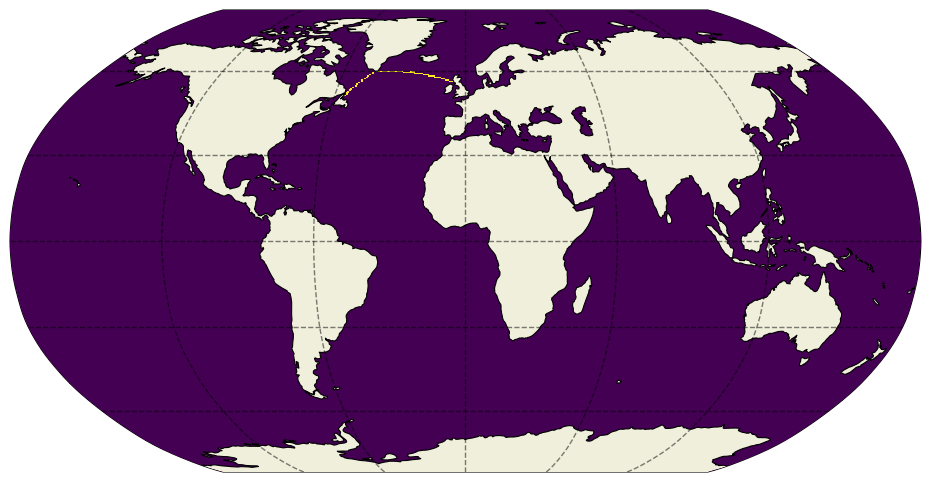

In [12]:
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,maskC_tot,cmap='viridis',projection_type='robin',user_lon_0=0);


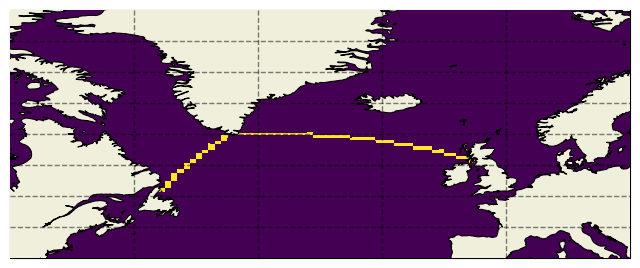

In [13]:
plt.figure(figsize=(8,8))
# use dx=.1, dy=.1 so that plot shows the osnap array as a thin 
# line.  remember, plot_proj_to_latlon_grid first interpolates
# the model grid to lat-lon with grid spacing as dx, dy
P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC, maskC_tot, \
                                cmap='viridis',\
                                projection_type='PlateCarree',\
                                lat_lim=45,dx=.1,dy=.1)
#ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
P[1].set_extent([-80, 20, 40, 80], crs=ccrs.PlateCarree())
plt.show()

We have defined many commonly used sections in oceanography so that users can access these easily. 
The available sections are shown below. 
This allows one to, e.g. compute volumetric transport across the Drake Passage as follows:

```
drake_vol = ecco_v4_py.calc_section_vol_trsp(ds,section_name='Drake Passage')
```

Similarly, we can do the same with `calc_section_heat_trsp` and `calc_section_salt_trsp`. 

One can also get these pre-defined section masks as follows:

```
pt1,pt2 = ecco_v4_py.get_section_endpoints('Drake Passage')
maskC, maskW, maskS = ecco_v4_py.get_section_line_masks(ds,pt1,pt2)
```

Finally, one can see similar functions in MATLAB:

* define general section masks: [gcmfaces_calc/gcmfaces_lines_transp.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/gcmfaces_lines_transp.m)

* see pre-defined section endpoints: [gcmfaces_calc/gcmfaces_lines_pairs.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/gcmfaces_lines_pairs.m)

In [14]:
ecco.get_available_sections()

['Bering Strait',
 'Gibraltar',
 'Florida Strait',
 'Florida Strait W1',
 'Florida Strait S1',
 'Florida Strait E1',
 'Florida Strait E2',
 'Florida Strait E3',
 'Florida Strait E4',
 'Davis Strait',
 'Denmark Strait',
 'Iceland Faroe',
 'Faroe Scotland',
 'Scotland Norway',
 'Fram Strait',
 'Barents Sea',
 'Labrador Greenland',
 'Hudson Strait',
 'English Channel',
 'Newfoundland Iberia',
 'Drake Passage',
 'Indonesia W1',
 'Indonesia W2',
 'Indonesia W3',
 'Indonesia W4',
 'Australia Antarctica',
 'Madagascar Channel',
 'Madagascar Antarctica',
 'South Africa Antarctica']

## Compute the overturning streamfunction in depth space

The function `calc_section_stf` computes the overturning streamfunction across the plane normal to the section denoted by the west and south masks. 
It is also possible to compute the overturning streamfunction at a particular latitude band, as is done to compare to the RAPID array, for instance. 
Please see the function `calc_meridional_stf` to do this, which is also in 
[ecco_v4_py.calc_stf](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_stf.py).

Note that we can also compute the volumetric, heat, or salt transport across these sections using the first three functions defined in [ecco_v4_py.calc_section_trsp](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_section_trsp.py).

In MATLAB, we can compute meridional overturning streamfunctions with [gcmfaces_calc/calc_overturn.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/calc_overturn.m).
Section transports can be computed with [gcmfaces_calc/calc_transports.m](https://github.com/gaelforget/gcmfaces/blob/readthedocs/gcmfaces_calc/calc_transports.m) once the masks are defined.

In [15]:
%%time

# compute streamfunctions, looping through individual time coordinates (this works more consistently in limited-memory environments)
for t in range(ds.sizes['time']):
    curr_osnap_z_stf_east = ecco.calc_section_stf(ds.isel(time=t),\
                                                  pt1=pt1_east, \
                                                  pt2=pt2_east,\
                                                  section_name='OSNAP East Overturning Streamfunction').compute()
    
    curr_osnap_z_stf_west = ecco.calc_section_stf(ds.isel(time=t), \
                                                  pt1=pt1_west, \
                                                  pt2=pt2_west,\
                                                  section_name='OSNAP West Overturning Streamfunction').compute()
    
    curr_osnap_z_stf_tot = ecco.calc_section_stf(ds.isel(time=t),\
                                                 maskW=maskW_tot, \
                                                 maskS=maskS_tot,\
                                                 section_name='OSNAP Total Overturning Streamfunction').compute()

    if t == 0:
        osnap_z_stf_east = copy.deepcopy(curr_osnap_z_stf_east)
        osnap_z_stf_west = copy.deepcopy(curr_osnap_z_stf_west)
        osnap_z_stf_tot = copy.deepcopy(curr_osnap_z_stf_tot)
    else:
        osnap_z_stf_east = xr.concat((osnap_z_stf_east,curr_osnap_z_stf_east),dim='time',\
                                     compat='override',data_vars='minimal',coords='minimal')
        osnap_z_stf_west = xr.concat((osnap_z_stf_west,curr_osnap_z_stf_west),dim='time',\
                                     compat='override',data_vars='minimal',coords='minimal')
        osnap_z_stf_tot = xr.concat((osnap_z_stf_tot,curr_osnap_z_stf_tot),dim='time',\
                                     compat='override',data_vars='minimal',coords='minimal')

2024-04-06 06:00:01,948 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('where-371e2800fd446dbdcb450f32d4db7792', 0, 0, 0),)
2024-04-06 06:03:00,946 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('where-371e2800fd446dbdcb450f32d4db7792', 0, 0, 0),)
2024-04-06 06:08:40,369 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('where-371e2800fd446dbdcb450f32d4db7792', 0, 0, 0),)


Wall time: 2min 51s


In [16]:
def osnap_depth_stf_vs_time(stf_ds,label):
    fig = plt.figure(figsize=(18,6))
    
    # Time evolving
    plt.subplot(1,4,(1,3))
    time_edge_extrap = np.hstack((stf_ds['time'].values[0] - (0.5*np.diff(stf_ds['time'].values[0:2])),\
                                  stf_ds['time'].values[:-1] + (0.5*np.diff(stf_ds['time'].values)),\
                                  stf_ds['time'].values[-1] + (0.5*np.diff(stf_ds['time'].values[-2:]))))
    Z_edge_extrap = np.hstack((np.array([0]),\
                               stf_ds['Z'].values[:-1] + (0.5*np.diff(stf_ds['Z'].values)),\
                               np.array([-6134.5])))
    plt.pcolormesh(time_edge_extrap,Z_edge_extrap,stf_ds['psi_moc'].T)
    plt.title('ECCOv4r4\nOverturning streamfunction across OSNAP %s [Sv]' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    cb = plt.colorbar()
    cb.set_label('[Sv]')
    
    plt.subplot(1,4,4)
    plt.plot(stf_ds['psi_moc'].mean('time'),stf_ds['Z'])
    plt.title('ECCOv4r4\nTime mean streamfunction, OSNAP %s' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('[Sv]')
    plt.grid()
    plt.show()

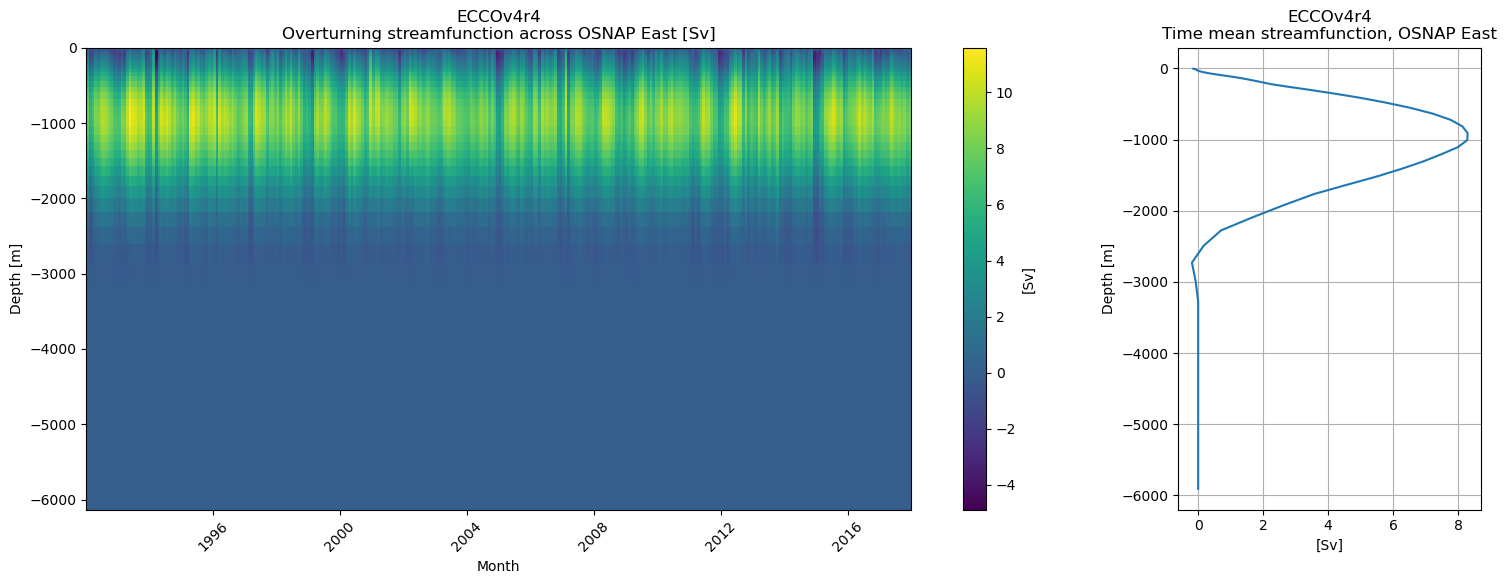

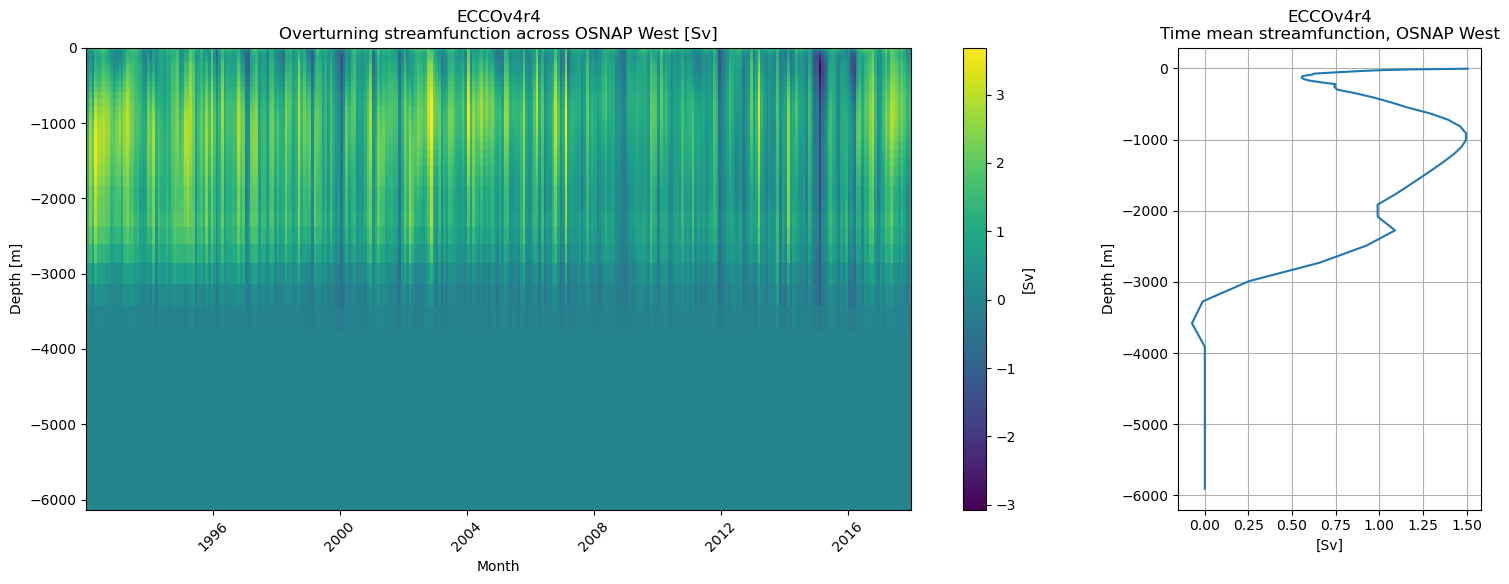

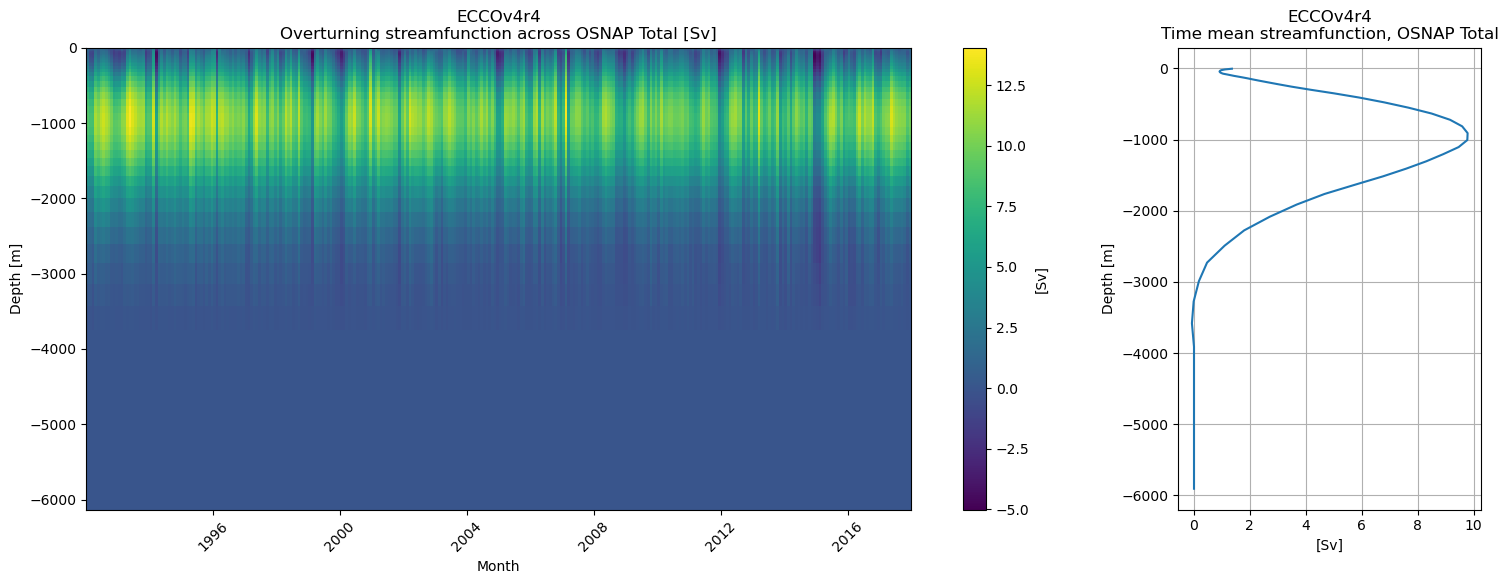

In [17]:
osnap_depth_stf_vs_time(osnap_z_stf_east,'East')
osnap_depth_stf_vs_time(osnap_z_stf_west,'West')
osnap_depth_stf_vs_time(osnap_z_stf_tot,'Total')

In [18]:
osnap_z_ov_east = osnap_z_stf_east['psi_moc'].max(dim='k')
osnap_z_ov_west = osnap_z_stf_west['psi_moc'].max(dim='k')
osnap_z_ov_tot = osnap_z_stf_tot['psi_moc'].max(dim='k')

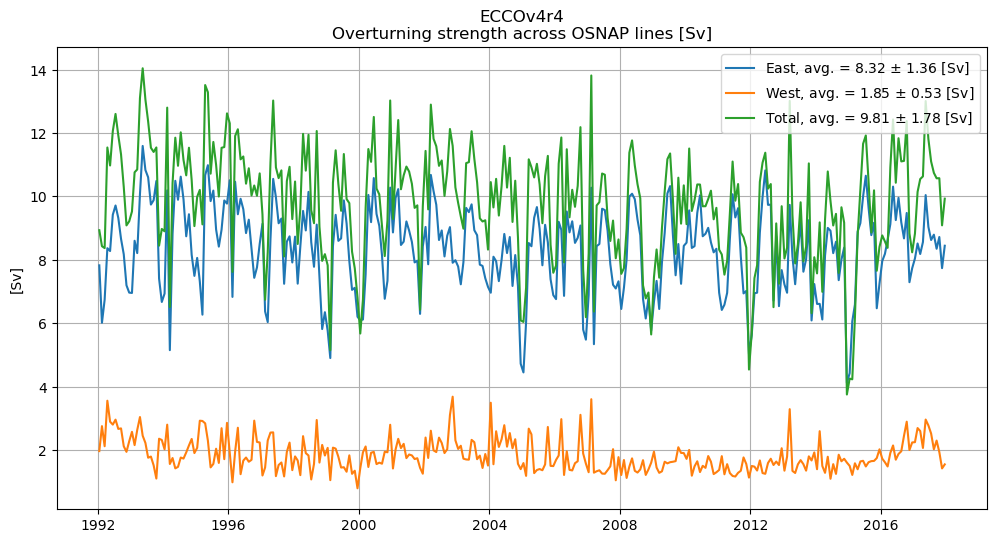

In [19]:
fig = plt.figure(figsize=(12,6))
plt.plot(osnap_z_ov_east['time'],osnap_z_ov_east)
plt.plot(osnap_z_ov_west['time'],osnap_z_ov_west)
plt.plot(osnap_z_ov_tot['time'],osnap_z_ov_tot)
plt.title('ECCOv4r4\nOverturning strength across OSNAP lines [Sv]')
plt.ylabel('[Sv]')
plt.legend((('East, avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_east.mean('time').values,osnap_z_ov_east.std('time').values)),
            ('West, avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_west.mean('time').values,osnap_z_ov_west.std('time').values)),
            ('Total, avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_tot.mean('time').values,osnap_z_ov_tot.std('time').values))))
plt.grid()
plt.show()

## Compare to Observations

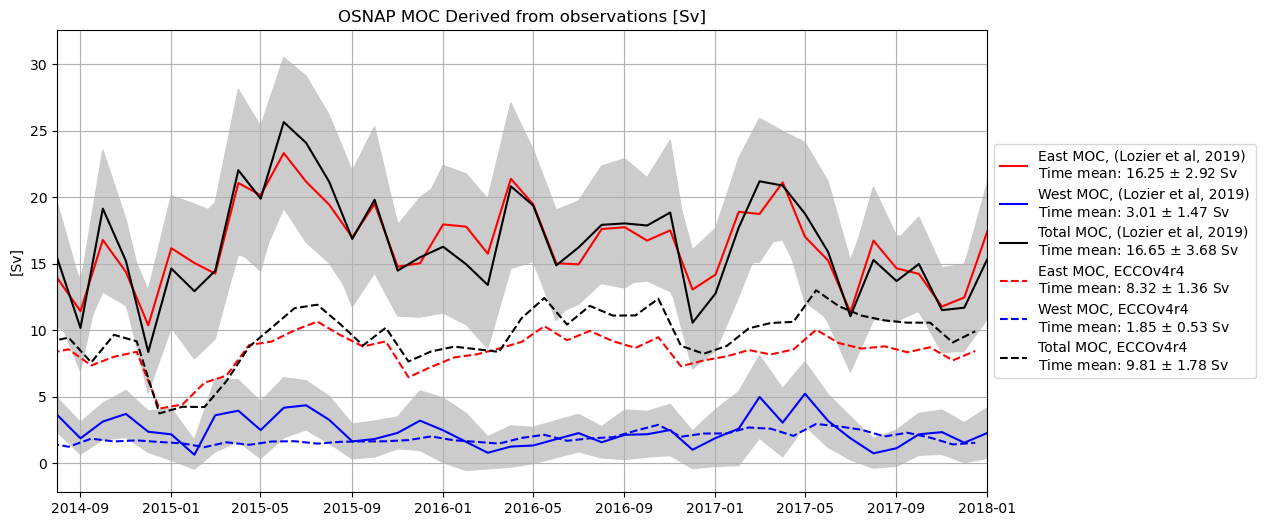

In [20]:
plt.figure(figsize=(12,6))

var_list = ['MOC_EAST','MOC_WEST','MOC_ALL']
err_list = ['MOC_EAST_ERR','MOC_WEST_ERR','MOC_ALL_ERR']
obs_handles = []
for var, err in zip(var_list,err_list):
    if 'MOC_ALL' in var:
        clr = 'k'
    elif 'MOC_EAST' in var:
        clr = 'r'
    elif 'MOC_WEST' in var:
        clr = 'b'
    
        
    curr_hand = plt.plot(obs['TIME'],obs[var], color=clr)
    obs_handles.append(curr_hand[0])
    
    plt.fill_between(obs['TIME'].values,
                 obs[var]-obs[err],
                 obs[var]+obs[err],
                 color=[0.8,0.8,0.8])

# plot ECCO v4r4 equivalent
ecco_hand0 = plt.plot(osnap_z_ov_east['time'],osnap_z_ov_east, 'r--')
ecco_hand1 = plt.plot(osnap_z_ov_west['time'],osnap_z_ov_west, 'b--',)
ecco_hand2 = plt.plot(osnap_z_ov_tot['time'],osnap_z_ov_tot, 'k--')
ecco_handles = [ecco_hand0[0],ecco_hand1[0],ecco_hand2[0]]
plt.xlim(np.array(['2014-08','2018-01']).astype('datetime64[ns]'))

plt.ylabel('[%s]' % obs['MOC_ALL'].units)
plt.grid()
plt.title('OSNAP MOC Derived from observations [%s]' % obs['MOC_ALL'].units)
plt.legend(handles=(obs_handles + ecco_handles),labels=(\
    ('East MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_EAST'].mean('TIME'),obs['MOC_EAST'].std('TIME'),obs['MOC_EAST'].units)),
    ('West MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_WEST'].mean('TIME'),obs['MOC_WEST'].std('TIME'),obs['MOC_WEST'].units)),
    ('Total MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_ALL'].mean('TIME'),obs['MOC_ALL'].std('TIME'),obs['MOC_ALL'].units)),
    ('East MOC, ECCOv4r4\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_east.mean('time'),osnap_z_ov_east.std('time'), \
             osnap_z_stf_east['psi_moc'].attrs['units'])),
    ('West MOC, ECCOv4r4\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_west.mean('time'),osnap_z_ov_west.std('time'), \
             osnap_z_stf_west['psi_moc'].attrs['units'])),
    ('Total MOC, ECCOv4r4\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_tot.mean('time'),osnap_z_ov_tot.std('time'), \
             osnap_z_stf_tot['psi_moc'].attrs['units']))),
    loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()